# Mixed precision transfer learning with PyTorch

In this example we'll implement fine-tuning and feature extracting mixed precision transfer learning using the CIFAR-10 dataset.

_This example is partially based on_ [https://github.com/pytorch/tutorials/blob/main/beginner_source/transfer_learning_tutorial.py](https://github.com/pytorch/tutorials/blob/main/beginner_source/transfer_learning_tutorial.py).<br/>
_The licensing information and the author of the base version are:<br/>
License: BSD<br/>
Author: Sasank Chilamkurthy_

In [1]:
!pip install torch
!pip install torchvision

Load the training data (`train_loader`):

In [2]:
import torch

from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision import transforms

batch_size = 50

train_data_transform = transforms.Compose([
    transforms.Resize(224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(
        [0.485, 0.456, 0.406],
        [0.229, 0.224, 0.225])
])

train_set = datasets.CIFAR10(
    root='data',
    train=True,
    download=True,
    transform=train_data_transform)

train_loader = DataLoader(
    dataset=train_set,
    batch_size=batch_size,
    shuffle=True,
    num_workers=2)

Files already downloaded and verified


Load the training data (train_loader):

In [3]:
val_data_transform = transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor(),
    transforms.Normalize(
        [0.485, 0.456, 0.406],
        [0.229, 0.224, 0.225])
])

val_set = datasets.CIFAR10(
    root='data',
    train=False,
    download=True,
    transform=val_data_transform)

val_order = DataLoader(
    dataset=val_set,
    batch_size=batch_size,
    shuffle=False,
    num_workers=2)

Files already downloaded and verified


Select device:

In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

Define `train_model` and `test_model` helper functions:

In [5]:
def train_model(model, loss_function, optimizer, data_loader):
    current_loss = 0.0
    current_acc = 0

    scaler = torch.cuda.amp.GradScaler()

    # iterate over the training data
    for i, (inputs, labels) in enumerate(data_loader):
        # zero the parameter gradients
        optimizer.zero_grad()

        with torch.autocast(
            device_type=device,
            dtype=torch.float16):
            # send the input/labels to the GPU
            inputs = inputs.to(device)
            labels = labels.to(device)

            # forward
            outputs = model(inputs)
            _, predictions = torch.max(outputs, 1)
            loss = loss_function(outputs, labels)

        # backward with scaler
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        # statistics
        current_loss += loss.item() * inputs.size(0)
        current_acc += torch.sum(predictions == labels.data)

    total_loss = current_loss / len(data_loader.dataset)
    total_acc = current_acc.double() / len(data_loader.dataset)

    print('Train Loss: {:.4f}; Accuracy: {:.4f}'.format(total_loss, total_acc))


def test_model(model, loss_function, data_loader):
    current_loss = 0.0
    current_acc = 0

    # iterate over  the validation data
    for i, (inputs, labels) in enumerate(data_loader):
        # send the input/labels to the GPU
        inputs = inputs.to(device)
        labels = labels.to(device)

        # forward
        outputs = model(inputs)
        _, predictions = torch.max(outputs, 1)
        loss = loss_function(outputs, labels)

        # statistics
        current_loss += loss.item() * inputs.size(0)
        current_acc += torch.sum(predictions == labels.data)

    total_loss = current_loss / len(data_loader.dataset)
    total_acc = current_acc.double() / len(data_loader.dataset)

    print('Test Loss: {:.4f}; Accuracy: {:.4f}'.format(total_loss, total_acc))

    return total_loss, total_acc

Define 2 functions that build transfer learning models for either feature extacting, or fine-tuning. Both models use the `torchvision.models.resnet18` ImageNet pretrained model. We'll start with feature extracting, which "locks" all model parameters (weights) except for the final fully-connected layer:


In [6]:
import torch.nn as nn
import torch.optim as optim
from torchvision.models import MobileNet_V3_Small_Weights, mobilenet_v3_small


def tl_feature_extractor(epochs=5):
    # load the pre-trained model
    model = mobilenet_v3_small(weights=MobileNet_V3_Small_Weights.IMAGENET1K_V1)

    # exclude existing parameters from backward pass
    # for performance
    for param in model.parameters():
        param.requires_grad = False

    # newly constructed layers have requires_grad=True by default
    num_features = model.classifier[0].in_features
    model.classifier = nn.Linear(num_features, 10)

    # transfer to GPU (if available)
    model = model.to(device)

    loss_function = nn.CrossEntropyLoss()

    # only parameters of the final layer are being optimized
    optimizer = optim.Adam(model.classifier.parameters())

    # train
    test_acc = list()  # collect accuracy for plotting
    for epoch in range(epochs):
        print('Epoch {}/{}'.format(epoch + 1, epochs))

        train_model(model, loss_function, optimizer, train_loader)
        _, acc = test_model(model, loss_function, val_order)
        test_acc.append(acc.cpu())

    plot_accuracy(test_acc)


def tl_fine_tuning(epochs=5):
    # load the pre-trained model
    model = mobilenet_v3_small(weights=MobileNet_V3_Small_Weights.IMAGENET1K_V1)

    # replace the last layer
    num_features = model.classifier[0].in_features
    model.classifier = nn.Linear(num_features, 10)

    # transfer the model to the GPU
    model = model.to(device)

    # loss function
    loss_function = nn.CrossEntropyLoss()

    # We'll optimize all parameters
    optimizer = optim.Adam(model.parameters())

    # train
    test_acc = list()  # collect accuracy for plotting
    for epoch in range(epochs):
        print('Epoch {}/{}'.format(epoch + 1, epochs))

        train_model(model, loss_function, optimizer, train_loader)
        _, acc = test_model(model, loss_function, val_order)
        test_acc.append(acc.cpu())

    plot_accuracy(test_acc)

Define the `plot_accuracy` function:

In [7]:
import matplotlib.pyplot as plt


def plot_accuracy(accuracy: list):
    """Plot accuracy"""
    plt.figure()
    plt.plot(accuracy)
    plt.xticks(
        [i for i in range(0, len(accuracy))],
        [i + 1 for i in range(0, len(accuracy))])
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.show()

Run the feature extractor model first:

Epoch 1/5
Train Loss: 1.0018; Accuracy: 0.6761
Test Loss: 0.7075; Accuracy: 0.7647
Epoch 2/5
Train Loss: 0.7667; Accuracy: 0.7375
Test Loss: 0.6473; Accuracy: 0.7797
Epoch 3/5
Train Loss: 0.7246; Accuracy: 0.7479
Test Loss: 0.6268; Accuracy: 0.7874
Epoch 4/5
Train Loss: 0.6955; Accuracy: 0.7583
Test Loss: 0.6064; Accuracy: 0.7902
Epoch 5/5
Train Loss: 0.6789; Accuracy: 0.7630
Test Loss: 0.5987; Accuracy: 0.7921


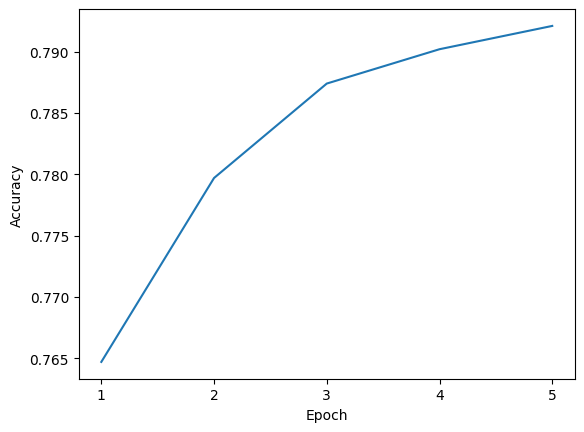

In [8]:
tl_feature_extractor()

Run the fine-tuning model next:

Epoch 1/5
Train Loss: 0.5283; Accuracy: 0.8162
Test Loss: 0.3635; Accuracy: 0.8739
Epoch 2/5
Train Loss: 0.3135; Accuracy: 0.8914
Test Loss: 0.3288; Accuracy: 0.8886
Epoch 3/5
Train Loss: 0.2497; Accuracy: 0.9125
Test Loss: 0.2956; Accuracy: 0.9019
Epoch 4/5
Train Loss: 0.2148; Accuracy: 0.9243
Test Loss: 0.2854; Accuracy: 0.9039
Epoch 5/5
Train Loss: 0.1818; Accuracy: 0.9363
Test Loss: 0.2920; Accuracy: 0.9014


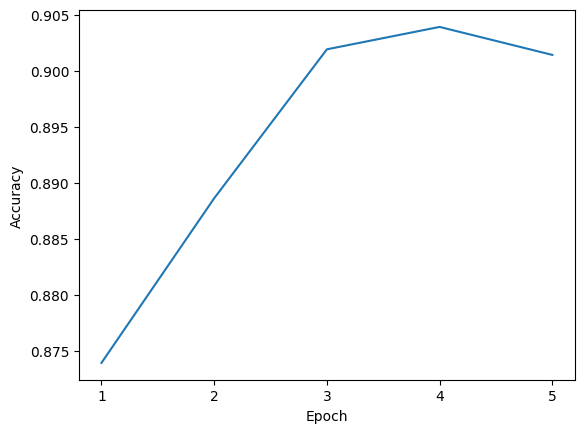

In [9]:
tl_fine_tuning()